# Evaluate

## Tess trained

In [11]:
import sys
from pathlib import Path

import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
module_path = str(Path.cwd().parents[0] / "network_models/w2v_emotion_model")
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.wav2Vec_utils as w2vU
import utils.audio_dataset_utils as ADU
import network_models.soundstream_lstm.LSTM_dataset as lds
import network_models.soundstream_lstm.CombinedEmoDataset_7_Emo as ced
import  network_models.w2v_emotion_model.custom_collator as cc
import network_models.w2v_emotion_model.custom_model as cm
import network_models.w2v_emotion_model.model_trainer as ct
import gc

model_name_or_path = "facebook/wav2vec2-large-960h-lv60-self"
pooling_mode = "mean"
device = "cuda"


emo_dataset = ced.CombinedEmoDataSet_7_emos(
    directory_tess="/home/ckwdani/Music/emotionDatasets/converted_mono/tess",
    #directory_cafe="/home/ckwdani/Music/emotionDatasets/converted_mono/cafe",
    #directory_ravdess="/home/ckwdani/Music/emotionDatasets/converted_mono/RAVDESS Audio_Speech_Actors_01-24",
                                             #directory_mesd="/home/ckwdani/Music/emotionDatasets/converted_mono/mesd",
                                             device=device)

processor, sr = w2vU.init_w2v2(num_labels=len(emo_dataset.label_list), label_list=emo_dataset.label_list, device=device)
newSet = lds.AudioEmotionTessWav2VecDataset(emo_dataset, processor= processor, sampling_rate=sr)

model = cm.Wav2Vec2ForSpeechClassification(model_name_or_path=model_name_or_path, pooling_mode="mean", device=device)
model.freeze_feature_extractor()


In [12]:
model.load_state_dict(torch.load("../content/classifier/W2VClassifier/Nr1/emo_reco_800.pth"))

<All keys matched successfully>

In [28]:
from torch.utils.data import DataLoader
import numpy
import torch.nn.functional as F
trainSet, evalSet = ADU.train_val_dataset(newSet, 0.1)
batch_size = 8
dataset = evalSet
data_collator = cc.DataCollatorCTCWithPadding(processor=processor, padding=True, num_labels=len(newSet.dataSet.label_list))
loader = DataLoader(dataset, shuffle=False, batch_size=batch_size, num_workers=1 ,collate_fn=data_collator.collate_fn)
true, preds = [], []
with torch.no_grad():
    for batch, (X, z) in enumerate(loader):
        gc.collect()
        X, z = X.to(device),  z.to(device)
        pred = model(X)
        labels = [torch.squeeze(a.nonzero()).item() for a in z]
        true = true + labels

        preds = preds + pred.argmax(1).cpu().numpy().tolist()
        gc.collect()
        #preds.append(pred.argmax(1))
        if batch % 10 == 0:
            print(f"{batch*batch_size} of {len(dataset)}")

# correct = 0
# with torch.no_grad():
#     for i in range(len(newSet)):
#         tensor = torch.tensor(newSet[i][0])
#         if(i%10 == 1):
#             print(f"{i} of {len(newSet)}")
#             print(f"correct: {correct*100/i} %")
#         if(model(torch.unsqueeze(tensor, dim=0)).argmax(1) == newSet[i][1][0]):
#             correct = correct + 1
        # print(5 == newSet[500][1][0])
        # print(newSet[500][1][0])
        # print(model(torch.unsqueeze(tensor, dim=0)))
    #print(model(torch.tensor(numpy.expand_dims(newSet[0], axis=0))))

/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/network_models/w2v_emotion_model/custom_model.py:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = softmax(y)


0 of 276
80 of 276
160 of 276
240 of 276


In [44]:
from sklearn.metrics import classification_report

print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        44
           1       0.95      0.97      0.96        36
           2       0.93      0.97      0.95        40
           3       0.81      0.96      0.88        46
           4       1.00      1.00      1.00        36
           5       0.00      0.00      0.00        36
           6       0.00      0.00      0.00        38

    accuracy                           0.71       276
   macro avg       0.66      0.69      0.68       276
weighted avg       0.67      0.71      0.69       276



['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['neutral' 'fear' 'neutral' 'surprise' 'sad' 'fear' 'sad' 'happy' 'angry'
 'happy' 'surprise' 'fear' 'fear' 'disgust' 'fear' 'surprise' 'disgust'
 'neutral' 'angry' 'neutral' 'happy' 'angry' 'neutral' 'surprise' 'angry'
 'disgust' 'happy' 'disgust' 'sad' 'surprise' 'happy' 'surprise' 'angry'
 'neutral' 'disgust' 'disgust' 'disgust' 'happy' 'angry' 'surprise'
 'happy' 'fear' 'sad' 'surprise' 'neutral' 'surprise' 'angry' 'surprise'
 'surprise' 'disgust' 'angry' 'angry' 'angry' 'angry' 'disgust' 'fear'
 'fear' 'neutral' 'surprise' 'fear' 'fear' 'sad' 'surprise' 'surprise'
 'disgust' 'angry' 'happy' 'neutral' 'surprise' 'happy' 'disgust' 'happy'
 'disgust' 'sad' 'angry' 'disgust' 'angry' 'neutral' 'fear' 'angry'
 'neutral' 'neutral' 'neutral' 'disgust' 'angry' 'angry' 'disgust' 'sad'
 'neutral' 'fear' 'happy' 'sad' 'happy' 'surprise' 'surprise' 'fear'
 'neutral' 'happy' 'angry' 'neutral' 'angry' 'fear' 'surprise' 'angry'
 'sad' 

<AxesSubplot: xlabel='test', ylabel='count'>

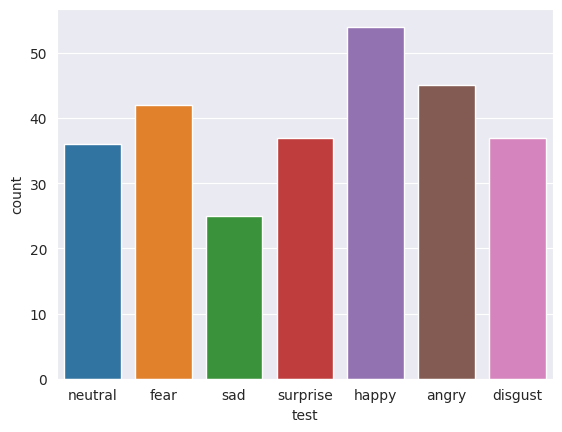

In [32]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame()
df1 = pd.DataFrame()
print(newSet.dataSet.label_list)
print(newSet.getEmotionFromId(true))

df["test"] = newSet.getEmotionFromId(preds)
df1["test"] = newSet.getEmotionFromId(true)
sns.countplot(x ="test", data= df)

# tensor = torch.tensor(newSet[324][0])
# model(torch.unsqueeze(tensor, dim=0)).argmax(1)

<AxesSubplot: xlabel='test', ylabel='count'>

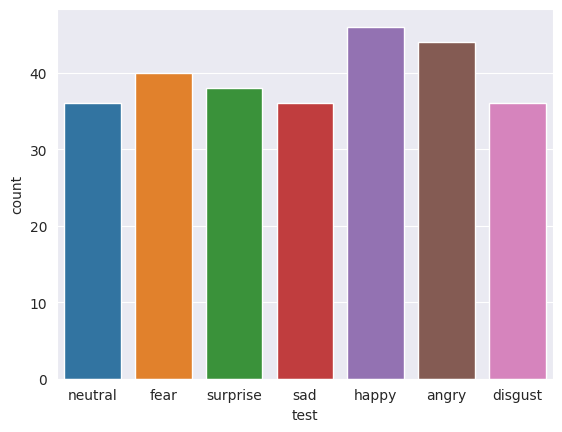

In [33]:
sns.countplot(x ="test", data= df1)